<a href="https://colab.research.google.com/github/aeshna25/LinkedIn-Connnections-Analysis/blob/main/Linkedin_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyjanitor pyvis --quiet

     |████████████████████████████████| 135 kB 26.2 MB/s 


In [2]:
! pip install ipython --quiet

In [12]:
import pandas as pd
import janitor #clean APIs for data cleaning
import datetime
from IPython.core.display import display, HTML
from pyvis import network as net #pyvis : visualize network graph 
import networkx as nx
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data= pd.read_csv('/content/drive/MyDrive/Data science Miscellaneous/Linkedin connection /Connections.csv',skiprows=2)

In [6]:
# data.shape #1116 , 6
data.head(4)

,First Name,Last Name,Email Address,Company,Position,Connected On
0,Falguni,Chitkara,NaN,Atlassian,Senior Software Engineer,18 Apr 2022
1,Yash,Rai,NaN,Google,IT Support Engineer,18 Apr 2022
2,Dwijraj,Bhattacharyya,NaN,Altimetrik,Engineer-Product and Platform Engineering,18 Apr 2022
3,Carl,Patrao,NaN,Atlassian,Regional Channel Lead (India & South Asia),18 Apr 2022


Columns:
1. First name
2. Last name
3. Email
4. Company
5. Position
6. Connected on (date)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116 entries, 0 to 1115
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     1105 non-null   object
 1   Last Name      1104 non-null   object
 2   Email Address  21 non-null     object
 3   Company        1068 non-null   object
 4   Position       1070 non-null   object
 5   Connected On   1116 non-null   object
dtypes: object(6)
memory usage: 52.4+ KB


In [8]:
data.isnull().sum()

First Name         11
Last Name          12
Email Address    1095
Company            48
Position           46
Connected On        0
dtype: int64

With this data, imputation won't work so we'll be removing the Email, names for privacy purpose 

In [9]:
data.drop(['Email Address','First Name','Last Name'],axis=1,inplace=True)
data.head(3)

,Company,Position,Connected On
0,Atlassian,Senior Software Engineer,18 Apr 2022
1,Google,IT Support Engineer,18 Apr 2022
2,Altimetrik,Engineer-Product and Platform Engineering,18 Apr 2022


Those records where Company is not present won't be of any help to us

In [10]:
data= data[data.Company.notnull()]
data.head(3)

,Company,Position,Connected On
0,Atlassian,Senior Software Engineer,18 Apr 2022
1,Google,IT Support Engineer,18 Apr 2022
2,Altimetrik,Engineer-Product and Platform Engineering,18 Apr 2022


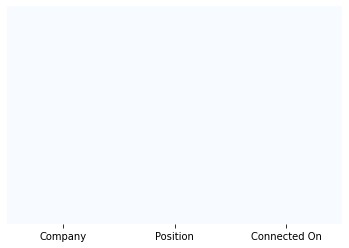

In [13]:
sns.heatmap(data.isnull(),yticklabels=False, cbar=False, cmap='Blues')

No missing values left now

Shape: (1055, 4) 94% of the total data





# EDA

In [14]:
from ipywidgets import interact_manual
import plotly.express as px
import seaborn as sns
import plotly
import plotly.express as px

In [15]:
data['Company frequency']= data['Company'].map(data['Company'].value_counts())
data.head(2)

,Company,Position,Connected On,Company frequency
0,Atlassian,Senior Software Engineer,18 Apr 2022,5
1,Google,IT Support Engineer,18 Apr 2022,32


In [16]:
data['Company']= data['Company'].str.replace('AIIMS (All India Institute of Medical Sciences, New Delhi)','AIIMS')
data['Company']= data['Company'].str.replace('Defence logistics Research and Development Organisation','DRDO')

data.replace('AIIMS (All India Institute of Medical Sciences, New Delhi)','AIIMS',inplace=True)
data.replace('Defence logistics Research and Development Organisation','DRDO',inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


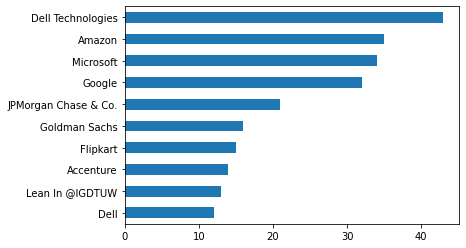

In [17]:
data['Company'].value_counts().head(10).plot(kind='barh').invert_yaxis()

Dell is dominating the dataset.
Lean In @igdtuw is my college commitee I'll remove it
also for Dell I have 3 entries: Dell Technologies, 	Dell International Services India Private Limited, Dell EMC and Dell. I'll join all under one umbrella

In [18]:
data= data[data.Company != 'Lean In @IGDTUW']
data.replace('Dell EMC', 'Dell', inplace=True)
data.replace('Dell Technologies','Dell', inplace=True)
data.replace('Dell International Services India Private Limited','Dell', inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


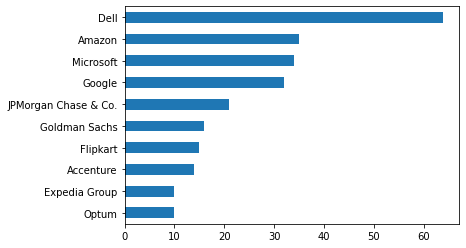

In [19]:
data['Company'].value_counts().head(10).plot(kind='barh').invert_yaxis()

After removing the unwanted data now Expedia and Optum has entered the top 10 list

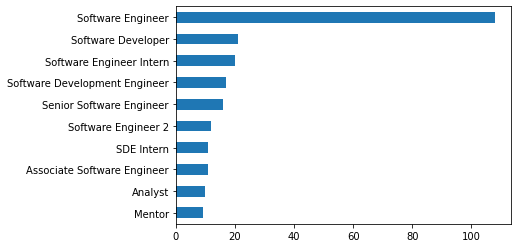

In [20]:
data['Position'].value_counts().head(10).plot(kind='barh').invert_yaxis()

Seems like the ratio od SE is way higher than the next one in line. This can be explained by the fact that I was more active in the initial years and didn't know any other domain except SE, SDE etc

Inclusion of Analyst in the top 10 shows the changing interest


In [21]:
px.histogram(data,'Connected On', nbins=30)

The hikes are interesting, most the hikes can be explained due to turning points in my career , in 2019 when I was looking out for (undergrad)internship jobs

In [22]:
company_count= data['Company'].value_counts().reset_index()
company_count.columns= ['Company','Count']
company_count.sort_values(by='Count',ascending=False, inplace=True)

# len(company_count.Company.unique()) # I am connected with people from 553 companies

In [23]:
nt= net.Network(notebook=True)

g= nx.Graph()
g.add_node('root') #taking myself as the centroid

for _, row in company_count.iterrows():

  # store company name and count
  company = row['Company']
  count = row['Count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in data[company == data['Company']]['Position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [24]:
position_count= data['Position'].value_counts().reset_index()
position_count.columns= ['Position','Count']
position_count.sort_values(by='Count',ascending=False, inplace=True)

# len(position_count.Position.unique()) #Its interesting to see my connection are working on 623 unique backgrounds


In [25]:
nt= net.Network(notebook=True)

g= nx.Graph()
g.add_node('root') #taking myself as the centroid

for _, row in position_count.iterrows():

  # store company name and count
  company = row['Position']
  count = row['Count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in data[company == data['Position']]['Company']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('position_graph.html')
display(HTML('position_graph.html'))

# Know the important people

At this stage of my career, I am looking forward to positions like Business analyst, data scientist, data analyst (positions related to data science) and people who are looking for people like HR, Talent acquisition, recuritor.

In [85]:
test_words =['Human','Talent','HR','Business Analyst','Data','Data analyst']
data['Keyword search'] = data['Position'].apply(lambda x : ','.join([item for item in str(x).split() if item.lower() in ['human','recruiter','talent','hr','business','Data','analyst','scientist','ml']]))

In [93]:
imp_people= data[data['Keyword search'] != '']['Keyword search']

Analyst             58
Talent              29
Human               20
Scientist           18
Business            13
HR                   9
Recruiter            8
Business,Analyst     7
HR,Talent            2
Talent,Recruiter     2
ML                   2
HR,Business          2
scientist            1
Human,Business       1
Human,Analyst        1
Name: Keyword search, dtype: int64


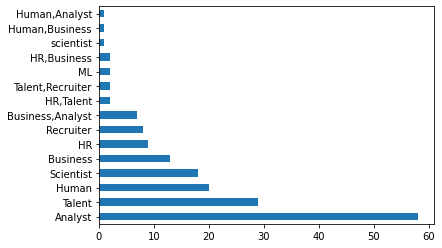

In [95]:
imp_people.value_counts().plot(kind='barh')

print(imp_people.value_counts())
